# PART IV : Part of Speech Tagging and Named Entity Recognition

I used this dataset from Kaggle for this task : https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus?select=ner.csv

This dataset is the extract from GMB(Groningen Meaning Bank) corpus which is tagged, annotated and built specifically to train the classifier to predict named entities such as name, location, etc.

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
from IPython.display import clear_output

import os, string, random, time, math
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from get_free_gpu import get_free_gpu

device = get_free_gpu()

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

## Load the data

At first this dataset comes in sentences but for this lab I just separated all the words and I will be predicting the class of each word.

In [2]:
import codecs
import shutil

with codecs.open("ner_dataset.csv", encoding="latin1") as input_file:
    with codecs.open(
            "output_file.utf8.csv", "w", encoding="utf-8") as output_file:
        shutil.copyfileobj(input_file, output_file)



data = pd.read_csv("output_file.utf8.csv", encoding="utf-8")
data = data.drop(['POS'], axis =1)
data = data.drop(['Sentence #'], axis =1)

data = data.fillna(method="ffill")

data.head(10)

,Word,Tag
0,Thousands,O
1,of,O
2,demonstrators,O
3,have,O
4,marched,O
5,through,O
6,London,B-geo
7,to,O
8,protest,O
9,the,O


In [3]:
# all unique words in the dataset
words = list(set(list(data['Word'].values)))
print(type(words))

# total number of words in the dataset
n_words = len(words)
print(n_words)

<class 'list'>
35178


In [4]:
# all possible tags in the dataset
tags = list(set(data["Tag"].values))

# total number of tags in the dataset
n_tags = len(tags)
print(n_tags)
print(tags)

17
['I-per', 'I-geo', 'B-nat', 'I-org', 'B-geo', 'B-org', 'I-nat', 'B-tim', 'I-eve', 'I-gpe', 'I-tim', 'B-per', 'B-eve', 'O', 'I-art', 'B-gpe', 'B-art']


Here are the meaning of the tags:

    geo = Geographical Entity
    org = Organization
    per = Person
    gpe = Geopolitical Entity
    tim = Time indicator
    art = Artifact
    eve = Event
    nat = Natural Phenomenon
    O   = other tags that is not a name entity

In [5]:
data = np.array(data)
data

array([['Thousands', 'O'],
       ['of', 'O'],
       ['demonstrators', 'O'],
       ...,
       ['to', 'O'],
       ['the', 'O'],
       ['attack', 'O']], dtype=object)

## Create lists of all words and all tags

In [6]:
# Build the category_lines dictionary, a list of names per language
category_words = {}
all_words_data = []
all_tags_data = []

for i in tags:
    category_words[i] = []


for word, tag in data:
    category_words[tag].append(word)
    all_words_data.append(word)
    all_tags_data.append(tag)
    
for i in tags:
    print(len(category_words[i]))
    
print(len(all_words_data))
print(len(all_tags_data))

17251
7414
201
16784
37644
20143
51
20333
253
198
6528
16990
308
887908
297
15870
402
1048575
1048575


## Train Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(all_words_data, all_tags_data, test_size = 0.2, random_state = 123, stratify = all_tags_data)

In [8]:
#count
print("The number of observations in the training data: ", len(X_train))
print("The number of observations in the test data: ", len(X_test))

The number of observations in the training data:  838860
The number of observations in the test data:  209715


In [14]:
#create simple rnn network 
class RNN_net(nn.Module):
    #Create a constructor
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_net, self).__init__()
        self.hidden_size = hidden_size 
        self.rnn_cell = nn.RNN(input_size, hidden_size)
        self.h20 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)

    #create a forward pass function
    def forward(self, input_, hidden = None, batch_size = 1):
        out, hidden = self.rnn_cell(input_.to(device), hidden)
        output = self.h20(hidden.view(-1, self.hidden_size))
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self, batch_size = 1):
        #function to init the hidden layers
        return torch.zeros(1, batch_size, self.hidden_size).to(device)

In [15]:
#function to run inference
def infer(net, name, device = device):
    name_ohe = name_rep(name).to(device)

    #get the output
    output, hidden = net(name_ohe)

    if type(hidden) is tuple: #for lSTM
        hidden = hidden[0]
    index = torch.argmax(hidden)

    return output

In [16]:
#create hidden layers
n_hidden = 128 #hidden layers count

#initialize the network
net = RNN_net(input_size=n_letters, hidden_size=n_hidden, output_size=n_tags).to(device)

In [20]:
#create an evaluation function 

def eval(net, n_points, topk, X_, y_, device = device):
    "Evaluation function"

    net = net.eval().to(device)
    data_ = dataloader(n_points, X_, y_)
    correct = 0

    #iterate
    for name, language, name_ohe, lang_rep in data_:
        
#         name = name.to(device)
#         language = language.to(device)
        name_ohe = name_ohe.to(device)
        lang_rep = lang_rep.to(device)
        
        

        #get the output
        output = infer(net, name, device)
        val, indices = output.topk(topk) #get the top k values
        indices = indices.to(device) #convert to devices
        
        if lang_rep in indices:
            correct += 1

    accuracy = correct/n_points
    return accuracy

In [22]:
#create a batched name rep

def batched_name_rep(names, max_word_size):
    rep = torch.zeros(max_word_size, len(names), n_letters)
    for name_index, name in enumerate(names):
        for letter_index, letter in enumerate(name):
            pos = all_letters.find(letter)
            rep[letter_index][name_index][pos] = 1
    return rep

In [23]:
#function to print the output

def print_char(name_reps):
    name_reps = name_reps.view((-1, name_reps.size()[-1]))
    for t in name_reps: 
        if torch.sum(t) == 0:
            print('<pad>')
        else:
            index = t.argmax()
            print(all_letters[index])

In [25]:
def batched_lang_rep(langs):
    rep = torch.zeros([len(langs)], dtype=torch.long)
    for index, lang in enumerate(langs):
        rep[index] = tags.index(lang)
    return rep

In [26]:
#create dataloader
def batched_dataloader(npoints, X_, y_, verbose=False, device = device):
    names = []
    langs = []
    X_lengths = []
    
    for i in range(npoints):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_]
        X_lengths.append(len(name))
        names.append(name)
        langs.append(lang)
    max_length = max(X_lengths)
    
    names_rep = batched_name_rep(names, max_length).to(device)
    langs_rep = batched_lang_rep(langs).to(device)
    
    padded_names_rep = torch.nn.utils.rnn.pack_padded_sequence(names_rep, X_lengths, enforce_sorted = False)
    
    if verbose:
        print(names_rep.shape, padded_names_rep.data.shape)
        print('--')
    
    if verbose:
        print(names)
        print_char(names_rep)
        print('--')
    
    if verbose:
        print_char(padded_names_rep.data)
        print('Lang Rep', langs_rep.data)
        print('Batch sizes', padded_names_rep.batch_sizes)
    
    
    return padded_names_rep.to(device), langs_rep

In [30]:
#parameters for batch training

net = RNN_net(n_letters, n_hidden, n_tags).to(device)
criterion = nn.NLLLoss().to(device)
opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [31]:
def train_batch(net, opt, criterion, n_points, device = device):
    
    net.train().to(device)
    opt.zero_grad()
    
    batch_input, batch_groundtruth = batched_dataloader(n_points, X_train, y_train, False, device)
    batch_input = batch_input.to(device)
    batch_groundtruth = batch_groundtruth.to(device)
    
    output, hidden = net(batch_input)
    
    loss = criterion(output, batch_groundtruth)
    
    loss.backward()
    opt.step()
    return loss

In [33]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5, device = device):
    net = net.to(device)
    criterion = nn.NLLLoss().to(device)
    opt = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    
    loss_arr = np.zeros(n_batches + 1)
    
    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]*i + train_batch(net, opt, criterion, batch_size, device))/(i + 1)
        
        if i%display_freq == display_freq-1:
            clear_output(wait=True)
            
            print('Iteration', i, 'Loss', loss_arr[i])
            # print('Top-1:', eval(net, len(X_test), 1, X_test, y_test), 'Top-2:', eval(net, len(X_test), 2, X_test, y_test))
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
            
    print('Top-1 Accuracy:', eval(net, len(X_test), 1, X_test, y_test, device), 'Top-2 Accuracy:', eval(net, len(X_test), 2, X_test, y_test, device))

Iteration 1499 Loss 0.35833823680877686


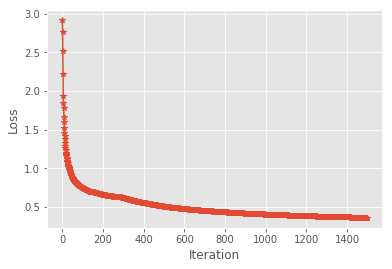




Top-1 Accuracy: 0.9259185084519467 Top-2 Accuracy: 0.9547671840354767
CPU times: user 9min 4s, sys: 9.21 s, total: 9min 13s
Wall time: 7min 46s


In [34]:
%%time

#training RNN using batch technique
net = RNN_net(n_letters, 128, n_tags)
train_setup(net, lr=0.15, n_batches=1500, batch_size = 512, display_freq=500)

# RESULTS

In this part, I did the name entity classification task on words extracted from GMB corpus.

We trained the model for 1500 batches and each batch has 512 words.

Training finished in 9 mins. We got the Top-1 accuracy of 92% and Top-2 Accuracy of 95% which is very good.

# CONCLUSION

This lab we learned about RNN and how to train them with batches of sequence and also to apply them to classfication of words from the sequence of letters.